### <img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393/578 Máquinas de Aprendizaje - 2019-1 </h1>

<H3 align='center'> Tarea 3 - Pregunta 1  </H3>
<H3 align='center'> Jorge Nuñez-Diego Alvarez  </H3>
<hr style="height:2px;border:none"/>

<a id="primero"></a>
## 1. Regresión para ubicación espacial

Un problema que tiene aplicaciones para muchos servicios es el calculo de la ubicación espacial exacta de un dispositivo conectado dentro de un edificio o un complejo de edificios. Estando dentro de un aeropuerto nuestro celular nos podría dar indicaciones para llegar a nuestra puerta de embarque o dentro de un mall encontrar la tienda que buscamos, serían aplicaciones que fácilmente se desprenden de la solución a este problema. Actualmente en exteriores el problema se soluciona fácilmente mediante el uso de GPS, sin embargo en interiores el problema se vuelve más complicado pues hay considerable pérdida de la señar GPS y muchas superficies de construcción pueden resultar reflectantes para algunos tipos de señales por lo cual el problema es mucho más dificil de modelar que el problema en el exterior. 


En esta primera parte de la tarea utilizaremos un _dataset_ creado en 2013 con más de 20000 mediciones de posición dentro de 4 edificios de la universidad de Jaume, disponible en https://archive.ics.uci.edu/ml/datasets/UJIIndoorLoc junto con una detallada descripción. Nuestra tarea será predecir la ubicación espacial en latitud, longitud, y altura (en pisos) de los distintos usuarios que realizaron esta tarea, a partir de las intensidades de señal medidas por los 520 distintos puntos de acceso inalambricos. Para esto, utilizaremos arboles de regresión, regresión lineal y redes neuronales, comparando los distintos desempeños y las ventajas y desventajas de cada aproximación. 

#### 1.a Carga de datos

Cargue los datos de entrenamiento y validación y júntelos en un solo DataFrame como muestra el código. 

De los datos entregados luego del _target_ solo consideraremos el tipo de celular utilizado, convirtiendolo a variables _dummies_ como muestra el código. 

Separe el _target_ del resto de los datos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold
from sklearn.linear_model import LinearRegression 
from sklearn import metrics
from sklearn.metrics import mean_squared_error as MSE
from sklearn.tree import DecisionTreeRegressor

In [3]:
df_tr = pd.read_csv("trainingData.csv")
df_val = pd.read_csv("validationData.csv")

df_t = shuffle(df_tr.append(df_val))

**Comentario :** Se utiliza el comando shuffle para unir los DF de manera aleatoria y evitando así un posible ordenamiento existente en el dataframe.

In [3]:
df_t.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
11994,100,100,100,100,100,100,100,100,100,100,...,100,-7363.159000,4.864768e+06,1,2,224,2,12,24,1371714663
17914,100,100,100,100,100,100,100,100,100,100,...,100,-7639.691000,4.864915e+06,3,0,205,2,1,14,1371055697
279,100,100,100,100,100,100,100,100,100,100,...,100,-7638.818726,4.864999e+06,2,0,0,0,0,13,1380035758
15224,100,100,100,100,100,100,100,100,100,100,...,100,-7316.867200,4.864814e+06,1,2,131,2,16,14,1371720496
9829,100,100,100,100,100,100,100,100,100,100,...,100,-7638.067700,4.865001e+06,0,0,133,2,11,13,1369910446


In [5]:
df_t.describe()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
count,21048.000000,21048.000000,21048.000000,21048.000000,21048.000000,21048.000000,21048.000000,21048.000000,21048.000000,21048.000000,...,21048.000000,21048.000000,2.104800e+04,21048.000000,21048.000000,21048.000000,21048.000000,21048.000000,21048.000000,2.104800e+04
mean,99.760500,99.830388,99.982326,99.982326,99.634122,97.281927,95.011640,93.845401,94.480758,99.145192,...,99.991733,-7467.702771,4.864873e+06,1.669137,1.188854,140.595211,1.736269,8.589367,12.963892,1.371906e+09
std,6.811116,5.643191,1.813086,1.813165,8.385624,22.327658,29.747638,32.964914,30.897265,12.765499,...,1.199344,124.084870,6.746981e+01,1.212608,0.838402,65.770099,0.547503,5.261661,5.437353,2.126924e+06
min,-97.000000,-90.000000,-87.000000,-88.000000,-97.000000,-98.000000,-99.000000,-99.000000,-98.000000,-99.000000,...,-74.000000,-7695.938755,4.864746e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.369909e+09
25%,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,-7601.616200,4.864821e+06,1.000000,0.000000,108.000000,2.000000,4.000000,8.000000,1.371709e+09
50%,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,-7425.661100,4.864854e+06,2.000000,1.000000,127.000000,2.000000,10.000000,13.000000,1.371716e+09
75%,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,-7359.331100,4.864930e+06,3.000000,2.000000,206.000000,2.000000,12.000000,14.000000,1.371721e+09
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,-7299.786517,4.865017e+06,4.000000,2.000000,254.000000,2.000000,18.000000,24.000000,1.381248e+09


In [18]:
df_t.nunique()

WAP001                  8
WAP002                  3
WAP003                  3
WAP004                  3
WAP005                 10
WAP006                 36
WAP007                 52
WAP008                 40
WAP009                 48
WAP010                 13
WAP011                 75
WAP012                 71
WAP013                 60
WAP014                 58
WAP015                 35
WAP016                 33
WAP017                 17
WAP018                 16
WAP019                 48
WAP020                 50
WAP021                 11
WAP022                 11
WAP023                 63
WAP024                 61
WAP025                 54
WAP026                 54
WAP027                 57
WAP028                 56
WAP029                 66
WAP030                 69
                    ...  
WAP500                 14
WAP501                 76
WAP502                 66
WAP503                 54
WAP504                 15
WAP505                  2
WAP506                 12
WAP507      

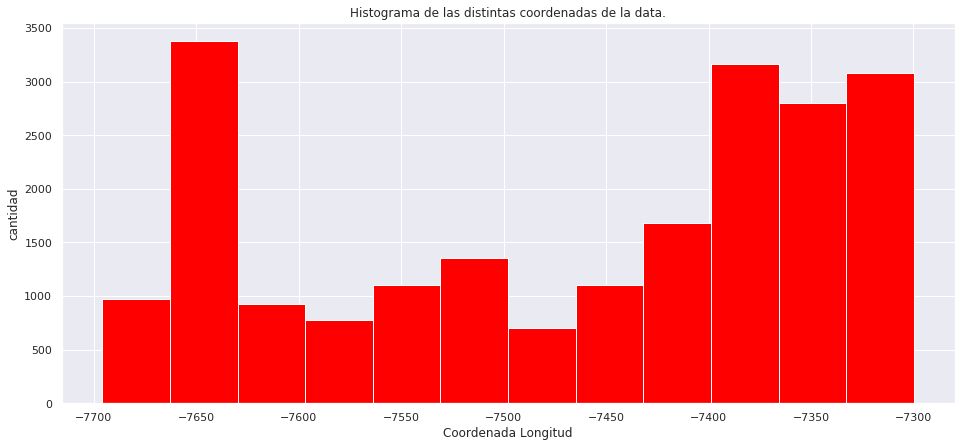

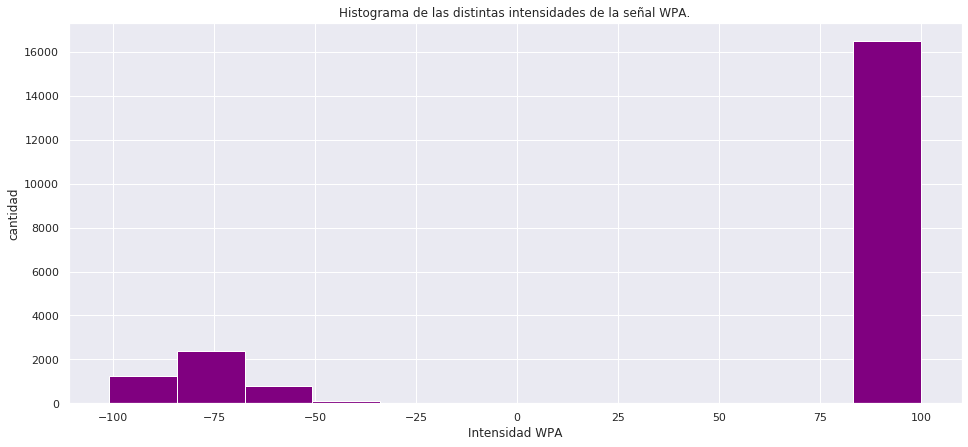

In [51]:
plt.figure(figsize=(16,7))
n, bins, patches = plt.hist(df_t['LONGITUDE'], 12, 
                            facecolor='red')
plt.title('Histograma de las distintas coordenadas de la data.')
plt.xlabel('Coordenada Longitud')
plt.ylabel('cantidad')
plt.show()

plt.figure(figsize=(16,7))
n, bins, patches = plt.hist(df_t['WAP517'], 12, 
                            facecolor='purple')
plt.title('Histograma de las distintas intensidades de la señal WPA.')
plt.xlabel('Intensidad WPA')
plt.ylabel('cantidad')
plt.show()

**Comentario:** Se observa que hay poca variabilidad en los datos de WPAxxx, considerando que se tienen más de 21.000 registros.

#### Descripción del DataFrame UJIndoorLoc.
Esta base de datas esta basada en la recopilación de huellas digitales WLAN (tambien conocidas como WIFI Fingerprinting).
A continuación se procede a describir las variables del problema.

|Columns                    | Descripción                           |
|:------------------------- |:------------------------------------- |
|WPA00x                     | Valor de intensidad para WPA          |
|LONGITUDE                  | Longitud (coordenada)                 |
|LATITUDE                   | Latitud (coordenada)                  |
|FLOOR                      | Altitud en piso (0-4)                 |
|BUILDINGID                 | ID del edificio (0-2)                 |
|SPACEID                    | ID espacio (oficina,corredor,aula)    |        
|RELATIVEPISITION           | Posición relativa (dentro o fuera)    |                                      
|USERID                     | ID del usuario                        |
|PHONEID                    | ID Dispositivo Android                |                
|TIMESTAMP                  | Hora registro                         |          


In [4]:
target_col =  df_t.columns[[520,521,522]] 
print (target_col)

Index(['LONGITUDE', 'LATITUDE', 'FLOOR'], dtype='object')


#### Se procede a eliminar las columnas de las variables que no seran utilizadas. Posteriormente se separa el target de las variables.

In [5]:
target_col =  df_t.columns[[520,521,522]] 
df = df_t.drop(columns=['BUILDINGID','SPACEID','RELATIVEPOSITION'
                        ,'USERID','TIMESTAMP']) 



#### Se separan los datos en 80 % train y 20 % validation.

In [6]:
Random_SEED = 42

In [7]:
df_tr, df_vl= train_test_split(df, test_size= 0.2
                                ,random_state = Random_SEED)


In [8]:
df_tr_col = df_tr.columns
phone_tr= pd.get_dummies(df_tr.PHONEID)
phone_col_tr=phone_tr.columns
index_tr =  phone_tr.head().index
phone_vl= pd.get_dummies(df_vl.PHONEID)
phone_col_vl=phone_vl.columns


**Comentario:** En este caso es valido separar la data de esta manera debido a que se habia aplicado la función shaflle en un principio, con lo cual se desordenan los datos, eviatndo de esta forma un posible orden existente en la data, con lo cual se perdería capacidad de generalizacion en el módelo.

#### 1.b Estandarización de los datos

Utilice _Standar Scaler_ para los atributos no categóricos y para los datos categóricos simplemente sustraiga 0.5, como muestra el código. ¿Tiene realmente sentido estandarizar los datos categóricos (binarios) o le parece mejor la aproximación elegida?

Estandarice igualmente el _target_. Cabe mencionar que la tercera componente del target es el piso en el que se encuentra, variable categórica, preferiremos utilizarla como variable continua para ver que tan bien nuestros algoritmos pueden aproximar la ubicación y para facilitar la comparación de distintos modelos. 

In [9]:
scaler = StandardScaler().fit(df_tr)

df_tr_scal = pd.DataFrame(scaler.transform(df_tr),
                           columns = df_tr_col)
phone_tr_scal=pd.DataFrame(phone_tr.values-0.5,
                             columns = phone_col_tr)
df_tr_scaler = pd.concat([df_tr_scal,phone_tr_scal], axis = 1,
                      join = 'inner')
                                 

df_vl_scal = pd.DataFrame(scaler.transform(df_vl),
                                 columns=df_vl.columns)
phone_vl_scal=pd.DataFrame(phone_vl.values-0.5,
                             columns = phone_col_vl)
df_vl_scaler = pd.concat([df_vl_scal,phone_vl_scal], axis = 1,
                      join = 'inner')

In [10]:
x_tr_scaler = df_tr_scaler.drop(columns=['LONGITUDE'
                        ,'LATITUDE','FLOOR','PHONEID'])

y_tr_scaler = df_tr_scaler[target_col]

x_vl_scaler = df_vl_scaler.drop(columns=['LONGITUDE'
                        ,'LATITUDE','FLOOR','PHONEID'])
y_vl_scaler = df_vl_scaler[target_col]


In [11]:
x_tr_scaler.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,15,16,17,18,19,20,21,22,23,24
0,0.03271,0.029859,0.007707,0.007707,0.042245,0.122141,0.168179,0.188611,0.180488,0.06732,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5
1,0.03271,0.029859,0.007707,0.007707,0.042245,0.122141,0.168179,0.188611,0.180488,0.06732,...,-0.5,-0.5,-0.5,-0.5,0.5,-0.5,-0.5,-0.5,-0.5,-0.5
2,0.03271,0.029859,0.007707,0.007707,0.042245,0.122141,0.168179,0.188611,0.180488,0.06732,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,0.5,-0.5,-0.5
3,0.03271,0.029859,0.007707,0.007707,0.042245,0.122141,0.168179,0.188611,0.180488,0.06732,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5
4,0.03271,0.029859,0.007707,0.007707,0.042245,0.122141,0.168179,0.188611,0.180488,0.06732,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5


In [12]:
y_tr_scaler.head()

,LONGITUDE,LATITUDE,FLOOR
0,1.217661,-0.869374,1.105130
1,0.562256,-1.288192,1.105130
2,0.013240,-0.190607,1.105130
3,0.622542,-0.542231,0.279641
4,-1.559580,0.978411,-1.371337


#### 1.c Primer Arbol
Entrenaremos ahora un árbol de regresión con produndidad 3. Como métrica utilizaremos el Error Absoluto Medio o MAE a lo largo del resto de esta pregunta. ¿Qué tan bueno le parece el _score_ (coeficiente $R^2$) obtenido por el regresor?

Compare el desempeño del árbol, tanto en MAE como en _score_, en validación y entrenamiento, con respecto a un regresor lineal tradicional. ¿Cómo se comparan los tiempos de entrenamiento? ¿Le parece justificado el costo adicional?

In [13]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(criterion='mae',
                            max_depth=3)
tree.fit(x_tr_scaler,y_tr_scaler)

DecisionTreeRegressor(criterion='mae', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [14]:
Y_vl_pred = pd.DataFrame(tree.predict(x_vl_scaler),
                      columns =target_col )
Y_tr_pred = pd.DataFrame(tree.predict(x_tr_scaler),
                      columns =target_col )

from sklearn.metrics import mean_squared_error as MSE
# LA PREDICCION DE FLOOR PRESENTA EL MAYOR MSE.
mse_val = MSE(y_vl_scaler, Y_vl_pred)
mse_tr = MSE(y_tr_scaler, Y_tr_pred)

In [15]:
Y_vl_pred.head()

,LONGITUDE,LATITUDE,FLOOR
0,0.928201,-0.952707,1.100843
1,0.342606,-0.272178,-0.546947
2,-1.194813,1.618170,0.276948
3,0.342606,-0.272178,-0.546947
4,0.342606,-0.272178,-0.546947


In [16]:

print('DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION')
print()
print('Score validation:')
print(tree.score(x_vl_scaler,y_vl_scaler))
print()
print('MSE validation :')
print(mse_val)
print()
print('Score training:')
print(tree.score(x_tr_scaler,y_tr_scaler))
print()
print('MSE training :')
print(mse_tr)

DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION

Score validation:
0.4235531966091855

MSE validation :
0.5677492672904855

Score training:
0.4379593326304821

MSE training :
0.562040667369518


/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-

#### Desarrollo mediante un modelo de regresión lineal tradicional múltiple

In [17]:
lr_multiple = LinearRegression()
lr_multiple.fit(x_tr_scaler,y_tr_scaler)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
Y_pred_multiple_vl = pd.DataFrame(lr_multiple.predict(x_vl_scaler),
                      columns =target_col )
Y_pred_multiple_tr = pd.DataFrame(lr_multiple.predict(x_tr_scaler),
                      columns =target_col )

In [19]:
Y_pred_multiple_tr.head()

,LONGITUDE,LATITUDE,FLOOR
0,-0.205475,-0.240753,0.157852
1,0.572388,-0.839661,-0.633759
2,0.721497,-0.427094,0.895699
3,0.357819,-0.818268,1.093025
4,-1.128632,1.638885,-1.067894


In [20]:
y_tr_scaler.head()

,LONGITUDE,LATITUDE,FLOOR
0,-0.356338,0.183466,0.276948
1,0.482507,-0.902833,-0.546947
2,0.750498,-0.252855,1.100843
3,0.667276,-1.417564,1.100843
4,-1.149000,1.554623,-0.546947


In [21]:
mse_LR_val = MSE(y_vl_scaler,Y_pred_multiple_vl)
mse_LR_tr = MSE(y_tr_scaler,Y_pred_multiple_tr)

In [22]:
print('DATOS DEL MODELO REGRESOR LINEAL MÚLTIPLE')
print()
print('Score validation:')
print(lr_multiple.score(x_vl_scaler,y_vl_scaler))
print()
print('MSE validation :')
print(mse_LR_val)
print()
print('Score training:')
print(lr_multiple.score(x_tr_scaler,y_tr_scaler))
print()
print('MSE training :')
print(mse_LR_tr)

DATOS DEL MODELO REGRESOR LINEAL MÚLTIPLE

Score validation:
-2.8403794318403894e+24

MSE validation :
2.797523261068435e+24

Score training:
0.9247090842891622

MSE training :
0.07529091571083789


/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-

#### Respuesta : 

**¿Cómo se comparan los tiempos de entrenamiento?**

El modelo de regresión arbol de decisión toma un tiempo de entrenamiento , alrededor de unas 70 veces mayor que el modelo de regresión lineal multiple.

|Modelo                     | Tiempo Entrenamiento  [s]   |
|:------------------------- |:---------------------------:|
|DecisionTreeRegressor      | 107 [s]                     | 
|LinearRegression           | 1.5 [s]                     |


**¿Le parece justificado el costo adicional?**

Para responder esta pregunta, primero realizaremos una comparación del desempeño de cada modelo (LinearRegression, DecisionTreeRegressor) y así determinar si es es justificado el costo computacional empleado en el arbol verus el de la regresion lineal. 

|Modelo                     | Accuracy [ Train ] | Accuracy [validtion]  |      
|:------------------------- |:------------------:|:---------------------:|
|DecisionTreeRegressor      |0.4412997732360018  | 0.4174114985077477    |   
|LinearRegression           |0.9246953778376582  | 0.0000000000000000    |

En base a los desempeños obtenidos por los modelos, se puede apreciar un claro sobre ajuste en el modelo LinearRegression, cambio el modelo DecisionTreeRegressor se comporta de mejor manera, no se observa sobreajuste u overfitting, pero su desmpeño es regular, pero falta realizar una exploración en la profundidad del árbol. 




#### 1.d _Stump_
Entrene ahora un _Stump_ o arbol de profundidad 1. ¿Cómo cambia el error (MAE) en entrenamiento y validación con respecto al árbol de la pregunta anterior? Discuta sobre el numero de parámetros entrenables que tendrá cada modelo.

In [53]:
stump =  DecisionTreeRegressor(criterion='mae',
                            max_depth= 1)
stump.fit(x_tr_scaler,y_tr_scaler)

DecisionTreeRegressor(criterion='mae', max_depth=1, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [54]:
Y_vl_pre = pd.DataFrame(stump.predict(x_vl_scaler),
                      columns =target_col )
Y_tr_pre = pd.DataFrame(stump.predict(x_tr_scaler),
                      columns =target_col )

from sklearn.metrics import mean_squared_error as MSE
# LA PREDICCION DE FLOOR PRESENTA EL MAYOR MSE.
mse_val_stump = MSE(y_vl_scaler, Y_vl_pre)
mse_tr_stump = MSE(y_tr_scaler, Y_tr_pre)

In [55]:
print('DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION STUMP')
print()
print('Score validation:')
print(stump.score(x_vl_scaler,y_vl_scaler))
print()
print('MSE validation :')
print(mse_val_stump)
print()
print('Score training:')
print(stump.score(x_tr_scaler,y_tr_scaler))
print()
print('MSE training :')
print(mse_tr_stump)

DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION STUMP

Score validation:
0.09867060514288468

MSE validation :
0.8936608943016747

Score training:
0.11101180366254383

MSE training :
0.8889881963374563


/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning:

The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').

/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning:

The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average'

#### Comparación de Desempeño Arboles profundidad 3 y 1.


|Modelo                       | Tiempo Entrenamiento  [s]   |
|:----------------------------|:---------------------------:|
|DecisionTreeRegressor (3)    | 107 [s]                     | 
|DecisionTreeRegressor (stump)| 48[s]                       |

|Modelo                     | Accuracy [ Train ] | Accuracy [validtion]  |      
|:------------------------- |:------------------:|:---------------------:|
|DecisionTreeRegressor (3)  | 0.4379593326304821 | 0.4235531966091855   |   
|DecisionTreeRegressor (stump)|0.11101180366254383 |0.09867060514288468| 

El árbol stump se demora la mitad del tiempo que demora el arbol de profundidad 3 en entrenarse.
El desempeño del árbol stump es claramente menor al alcanzado por el arbol de profundidad 3.

#### 1.e Profundidad máxima
Explore distintos valores de la profundidad máxima del árbol. Para esto, realice K-fold sobre al menos 10 valores distintos de la profundidad del árbol y compare el promedio de los MAE de validación. También guarde los promedios de MAE de _train_ y grafique como estos varían a medida varia la profundidad máxima. Idealmente debería considerar un rango entre profundidad máxima 1 y 20. Note que este paso puede resultar largo en tiempo de cómputo, podría ser recomendable correrlo en _Collab_ en caso de tener máquinas más lentas. 

Finalmente, entrene el arbol con profundidad óptima sobre todos los datos de entrenamiento y calcule su MAE sobre validación. ¿Mejoramos el desempeño obtenido anteriormente con los árboles sin sintonizar? 

In [26]:
df_col = df.columns
phone= pd.get_dummies(df.PHONEID)
phone_col=phone.columns
index =  phone.head().index

scaler = StandardScaler().fit(df)

df_scal = pd.DataFrame(scaler.transform(df),
                           columns = df_col)
phone_scal=pd.DataFrame(phone.values-0.5,
                             columns = phone_col)
df_scaler = pd.concat([df_scal,phone_scal], axis = 1,
                      join = 'inner')

In [27]:
scaler = StandardScaler().fit(df)

df_scal = pd.DataFrame(scaler.transform(df),
                           columns = df_col)
phone_scal=pd.DataFrame(phone.values-0.5,
                             columns = phone_col)
df_scaler = pd.concat([df_scal,phone_scal], axis = 1,
                      join = 'inner')
                                 

In [28]:
X_Scaler = df_scaler.drop(columns=['LONGITUDE'
                        ,'LATITUDE','FLOOR','PHONEID'])

Y_Scaler = df_scaler[target_col]

In [29]:
X_Scaler.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,15,16,17,18,19,20,21,22,23,24
0,0.035164,0.030057,0.009748,0.009748,0.043633,0.121739,0.167693,0.186706,0.178636,0.066964,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5
1,0.035164,0.030057,0.009748,0.009748,0.043633,0.121739,0.167693,0.186706,0.178636,0.066964,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5
2,0.035164,0.030057,0.009748,0.009748,0.043633,0.121739,0.167693,0.186706,0.178636,0.066964,...,-0.5,0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5
3,0.035164,0.030057,0.009748,0.009748,0.043633,0.121739,0.167693,0.186706,0.178636,0.066964,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5
4,0.035164,0.030057,0.009748,0.009748,0.043633,0.121739,0.167693,0.186706,0.178636,0.066964,...,-0.5,-0.5,-0.5,-0.5,0.5,-0.5,-0.5,-0.5,-0.5,-0.5


In [30]:
Y_Scaler.head()

,LONGITUDE,LATITUDE,FLOOR
0,0.693218,-0.396805,-0.551830
1,0.078783,-0.611194,0.272859
2,0.439613,-1.234513,1.922236
3,1.047587,-0.700261,0.272859
4,0.928278,-0.578528,1.922236


In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as MSE
len(df_scaler)

21048

In [1]:
## quiebre ciclo for de abajo demora mucho.
kk

In [ ]:
folds = KFold(n_splits=5)
MSE_val_r_k = []
space_r= []
MSE_train_r_k = []
#for lambd in range(1,41):
    MSE_val_fold=[]
    MSE_train_fold=[]
    for train_index,val_index in (folds.split(X_Scaler)):
        y_i = Y_Scaler
        y_tr = ((y_i.iloc[train_index]))
        x_tr = X_Scaler.iloc[train_index]
        y_vl = ((y_i.iloc[val_index]))
        x_vl = X_Scaler.iloc[val_index] 
        clf = DecisionTreeRegressor(criterion='mae',
                            max_depth= lambd)
        clf.fit(x_tr,y_tr)
        Y_val_pred = clf.predict(x_vl)
        Y_train_pred = clf.predict(x_tr)
        mse_val= MSE(Y_val_pred,y_vl)
        mse_train= MSE(Y_train_pred,y_tr)
        MSE_val_fold.append(mse_val)
        MSE_train_fold.append(mse_train)
    MSE_val_r_k.append(np.mean(MSE_val_fold))
    MSE_train_r_k.append(np.mean(MSE_train_fold))




#### Cargar datos para graficos.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
Tree_maxdepth = pd.read_csv('Tree_maxdepth.csv', index_col=0, parse_dates=True)
Tree_maxdepth.head()

,mse_train,mse_validation
max_depth,,
1,0.890948,0.890964
2,0.680289,0.680461
3,0.562890,0.563398
4,0.441870,0.446055
5,0.387425,0.392947


In [34]:
Tree_maxdepth.index

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40],
           dtype='int64', name='max_depth')

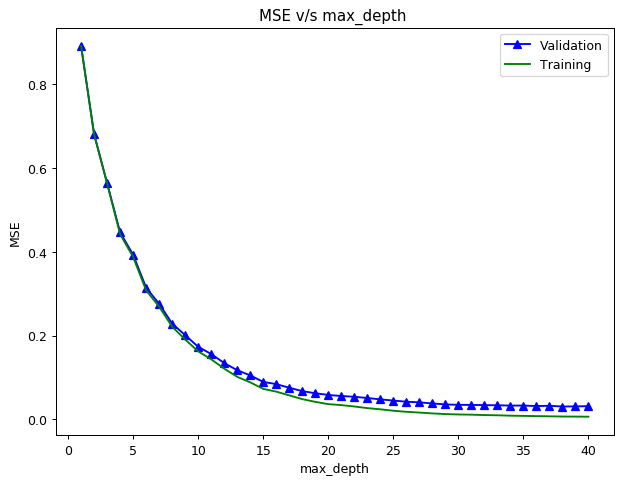

In [3]:

plt.figure(figsize=(8,6), dpi=90)
plt.plot(Tree_maxdepth.index,Tree_maxdepth['mse_validation'],'-b^', label = 'Validation')
plt.plot(Tree_maxdepth.index,Tree_maxdepth['mse_train'],color ='g', label = 'Training' )
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.title('MSE v/s max_depth ')
plt.legend(loc='upper right')

#plt.tight_layout()
plt.show()

#### Zoom de la parte donde se estabiliza el error de validación, si no esta cargado el grafico ejecutar la celda estań los datos guardados.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
Tree_maxdepth = pd.read_csv('Tree_maxdepth.csv', index_col=0, parse_dates=True)

import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks as cf
cf.go_offline(connected=True)
init_notebook_mode(connected=True)
Tree_maxdepth['mse_validation'][20:].iplot(kind='line', xTitle='max_depth', color='cornflowerblue',
                  yTitle='MSE', title='MSE_validation   DecisionTreeRegresion')

#### Profundidad optima es igual a 30, debido a que en hasta esta profundidad la validación presenta siempre mejora, más allá de esta profundidad el modelo comienza a experimentar una expecie a overfitting ya que el MSE comienxa a oscilar mejorando y empeorando.

In [56]:
from sklearn.tree import DecisionTreeRegressor

tree30 = DecisionTreeRegressor(criterion='mae',
                            max_depth=30)
tree30.fit(x_tr_scaler,y_tr_scaler)

DecisionTreeRegressor(criterion='mae', max_depth=30, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [57]:
Y_vl_pred30 = pd.DataFrame(tree30.predict(x_vl_scaler),
                      columns =target_col )
Y_tr_pred30 = pd.DataFrame(tree30.predict(x_tr_scaler),
                      columns =target_col )

from sklearn.metrics import mean_squared_error as MSE
# LA PREDICCION DE FLOOR PRESENTA EL MAYOR MSE.
mse_val30 = MSE(y_vl_scaler, Y_vl_pred30)
mse_tr30 = MSE(y_tr_scaler, Y_tr_pred30)

In [58]:
print('DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION')
print()
print('Score validation:')
print(tree30.score(x_vl_scaler,y_vl_scaler))
print()
print('MSE validation :')
print(mse_val30)
print()
print('Score training:')
print(tree30.score(x_tr_scaler,y_tr_scaler))
print()
print('MSE training :')
print(mse_tr30)

DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION

Score validation:
0.9641686988736787

MSE validation :
0.03552644881133282

Score training:
0.9881821592703579

MSE training :
0.01181784072964199


/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning:

The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').

/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning:

The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average'

#### Comparación de resultados obtenidos, con resultados previos.


|Modelo                       | Tiempo Entrenamiento  [s]   |
|:----------------------------|:---------------------------:|
|DecisionTreeRegressor (3)    | 107 [s]                     | 
|DecisionTreeRegressor (stump)| 48[s]                       |
|DecisionTreeRegressor (30)   | 180 [s]

|Modelo                     | Accuracy [ Train ] | Accuracy [validtion]  |      
|:------------------------- |:------------------:|:---------------------:|
|DecisionTreeRegressor (3)  | 0.4379593326304821 | 0.4235531966091855   |   
|DecisionTreeRegressor (stump)|0.11101180366254383 |0.09867060514288468|
|DecisionTreeRegressor (30) |0.9881821592703579|0.9641686988736787|

Al aumentar la profundidad máxima del arbol se obtiene una natable mejora obteniendose un score tanto entrain como validation cercanos a 1, esto es muy bueno ya que el modelo no experimenta sobreajuste, y presenta una buena capacidad de generalización. El tiempo de computo es aproximadamente un tercio mayor al árbol de profundidad 3, este tiempo extra queda más que justificado ante la notable mejora del módelo. Tambien cabe mencionar que comparando los resultados obtenidos del modelo sin k-fold con el obtenido mediante k-fold los resulstados en validación son muy parecidos.

In [66]:
from sklearn.tree import DecisionTreeRegressor

tree60 = DecisionTreeRegressor(criterion='mae',
                            max_depth=200)
tree60.fit(x_tr_scaler,y_tr_scaler)

DecisionTreeRegressor(criterion='mae', max_depth=200, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [67]:
Y_vl_pred60 = pd.DataFrame(tree60.predict(x_vl_scaler),
                      columns =target_col )
Y_tr_pred60 = pd.DataFrame(tree60.predict(x_tr_scaler),
                      columns =target_col )

from sklearn.metrics import mean_squared_error as MSE
# LA PREDICCION DE FLOOR PRESENTA EL MAYOR MSE.
mse_val60 = MSE(y_vl_scaler, Y_vl_pred60)
mse_tr60 = MSE(y_tr_scaler, Y_tr_pred60)

In [68]:
print('DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION')
print()
print('Score validation:')
print(tree60.score(x_vl_scaler,y_vl_scaler))
print()
print('MSE validation :')
print(mse_val60)
print()
print('Score training:')
print(tree60.score(x_tr_scaler,y_tr_scaler))
print()
print('MSE training :')
print(mse_tr60)

DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION

Score validation:
0.9706288448759862

MSE validation :
0.029121265659998025

Score training:
0.9941722178037466

MSE training :
0.00582778219625337


/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning:

The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').

/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning:

The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average'

#### 1.f Random Forest

En la pregunta anterior vimos que una profundidad de árbol muy grande puede llevarnos a _overffiting_, pues la cantidad de "decisiones" que puede aprender el modelo aumentan significativamente y el modelo tenderá a aprender de memoria el conjunto de entrenamiento, perdiendo capacidad de generalización. Otra aproximación para evitar _overffiting_ no utilizar todos los datos para entrenar, estrategia implementada por _Random Forest_. 

Discuta por qué el utilizar muchos modelos que no conocen todos los datos puede ayudar a mejorar la capacidad de generalización, evitando así que el modelo final este sobreajustado. Entrene luego un _Random Forest Regressor_, con a lo menos 10 árboles. Discuta sobre que elección realizar sobre la profundidad máxima de estos árboles. ¿Cómo se compara el desempeño de _Random Forest_ frente a un árbol por si solo?

In [52]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=20,
                               criterion='mae',
                               max_depth=5,
                               verbose=1)
forest.fit(x_tr_scaler,y_tr_scaler)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 19.1min finished


RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=1, warm_start=False)

In [53]:
Y_vl_pre = pd.DataFrame(forest.predict(x_vl_scaler),
                      columns =target_col )
Y_tr_pre = pd.DataFrame(forest.predict(x_tr_scaler),
                      columns =target_col )

from sklearn.metrics import mean_squared_error as MSE
# LA PREDICCION DE FLOOR PRESENTA EL MAYOR MSE.
mse_val_RF5 = MSE(y_vl_scaler, Y_vl_pre)
mse_tr_RF5 = MSE(y_tr_scaler, Y_tr_pre)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


In [54]:
print('DATOS DEL MODELO RANDOMFOREST 5')
print()
print('Score validation:')
print(forest.score(x_vl_scaler,y_vl_scaler))
print()
print('MSE validation :')
print(mse_val_RF5)
print()
print('Score training:')
print(forest.score(x_tr_scaler,y_tr_scaler))
print()
print('MSE training :')
print(mse_tr_RF5)

DATOS DEL MODELO RANDOMFOREST 5

Score validation:
0.6487380883380549

MSE validation :
0.34596200690164575

Score training:
0.6608232783675441

MSE training :
0.3391767216324561


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exp

In [70]:
from sklearn.tree import DecisionTreeRegressor

tree5 = DecisionTreeRegressor(criterion='mae',
                            max_depth=5)
tree5.fit(x_tr_scaler,y_tr_scaler)

DecisionTreeRegressor(criterion='mae', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [71]:
Y_vl_pred5 = pd.DataFrame(tree5.predict(x_vl_scaler),
                      columns =target_col )
Y_tr_pred5 = pd.DataFrame(tree5.predict(x_tr_scaler),
                      columns =target_col )

from sklearn.metrics import mean_squared_error as MSE
# LA PREDICCION DE FLOOR PRESENTA EL MAYOR MSE.
mse_val5 = MSE(y_vl_scaler, Y_vl_pred5)
mse_tr5 = MSE(y_tr_scaler, Y_tr_pred5)

In [72]:
print('DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION')
print()
print('Score validation:')
print(tree5.score(x_vl_scaler,y_vl_scaler))
print()
print('MSE validation :')
print(mse_val5)
print()
print('Score training:')
print(tree5.score(x_tr_scaler,y_tr_scaler))
print()
print('MSE training :')
print(mse_tr5)

DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION

Score validation:
0.6112522080082514

MSE validation :
0.3828822933284155

Score training:
0.620787725430058

MSE training :
0.37921227456994216


/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-

#### RandomForest, max_depth = 1 

In [73]:
from sklearn.ensemble import RandomForestRegressor
forest1 = RandomForestRegressor(n_estimators=40,
                               criterion='mae',
                               max_depth=1,
                               verbose=1)
forest1.fit(x_tr_scaler,y_tr_scaler)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 13.9min finished


RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=1,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=1, warm_start=False)

In [76]:
Y_vl_pre1 = pd.DataFrame(forest1.predict(x_vl_scaler),
                      columns =target_col )
Y_tr_pre1 = pd.DataFrame(forest1.predict(x_tr_scaler),
                      columns =target_col )

from sklearn.metrics import mean_squared_error as MSE
# LA PREDICCION DE FLOOR PRESENTA EL MAYOR MSE.
mse_val_RF1 = MSE(y_vl_scaler, Y_vl_pre1)
mse_tr_RF1 = MSE(y_tr_scaler, Y_tr_pre1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


In [77]:
print('DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION')
print()
print('Score validation:')
print(forest1.score(x_vl_scaler,y_vl_scaler))
print()
print('MSE validation :')
print(mse_val_RF1)
print()
print('Score training:')
print(forest1.score(x_tr_scaler,y_tr_scaler))
print()
print('MSE training :')
print(mse_tr_RF1)

DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION

Score validation:
0.2192455532501477

MSE validation :
0.7689742790983797

Score training:
0.20980063430561

MSE training :
0.7901993656943901


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exp

#### Comparación de desempeños modelos de DecisionTree vs RandomForest

|Modelo                       | Tiempo Entrenamiento  [s]   |
|:----------------------------|:---------------------------:|
|DecisionTreeRegressor (5)    | 115 [s]                     | 
|RandomForest (5) (20)        | 1.146 [s]                   |
|DecisionTreeRegressor (stump)| 48[s]                       |
|RandomForest (1) (40)        | 843 [s]                     |
|DecisionTreeRegressor (30)   | 180 [s]                     |


|Modelo                     | Accuracy [ Train ] | Accuracy [validtion]  |      
|:------------------------- |:------------------:|:---------------------:|
|DecisionTreeRegressor (5)  | 0.620787725430058 | 0.6112522080082514 |  
|RandomForest (5) (20)      |0.6608232783675441|0.6487380883380549|
|DecisionTreeRegressor (stump)|0.11101180366254383 |0.09867060514288468|
|RandomForest (1) (40)      |0.20980063430561|0.2192455532501477|
|DecisionTreeRegressor (30) |0.9881821592703579|0.9641686988736787|

En base a los resultados obtenidos se aprecia una mejora en los modelos de RandomForest, pero no muy significativa, esta mejora no justifica el elevado tiempo computacional que implican estos modelos, con lo cual no se justificaria su aplicación a este tipo de problemas, RandomForest es bueno aplicarlos a Datas que están propensas al sobreajuste, con lo cual se logra una mejora significativa en la validación. No se aplica para mayores profundidad en este caso debido a que no se aprecia sobreajuste en la exploración realizada en el item (e).

#### Intento de sobreajustar el modelo.

In [22]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(criterion='mae',
                            max_depth=2000000)
tree.fit(x_tr_scaler,y_tr_scaler)

DecisionTreeRegressor(criterion='mae', max_depth=2000000, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [23]:
Y_vl_pred = pd.DataFrame(tree.predict(x_vl_scaler),
                      columns =target_col )
Y_tr_pred = pd.DataFrame(tree.predict(x_tr_scaler),
                      columns =target_col )

from sklearn.metrics import mean_squared_error as MSE
# LA PREDICCION DE FLOOR PRESENTA EL MAYOR MSE.
mse_val = MSE(y_vl_scaler, Y_vl_pred)
mse_tr = MSE(y_tr_scaler, Y_tr_pred)

In [24]:
print('DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION')
print()
print('Score validation:')
print(tree.score(x_vl_scaler,y_vl_scaler))
print()
print('MSE validation :')
print(mse_val)
print()
print('Score training:')
print(tree.score(x_tr_scaler,y_tr_scaler))
print()
print('MSE training :')
print(mse_tr)

DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION

Score validation:
0.9738617548492928

MSE validation :
0.025838705095047546

Score training:
0.9960058099118688

MSE training :
0.003994190088131206


/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-

#### 1.g Otros parámetros

Por último, investigue un poco sobre los otros parámetros de los árboles y sus implicancias. Luego, entrene un arbol modificando algunos de sus parámetros de una forma que piensen podría haber mejorado el desempeño. Discuta

#### DecisionTreeRegressor

|Parámetros                   | Significado                 |
|:----------------------------|:---------------------------|
| criterion  | Función de perdida utilizado por el modelo "mse" o "mae" | 
|max_depth|Profundidad máxima del árbol, una mayor profundidad permite aprender relaciones más especificas, debe ajustarse con validación cruzada|
|max_features     |Cantidad de caracteristicas a considerar cuando se busca la mejor división, por general se utiliza raiz cuadrada del total de atributos, porbar un 30 a 40 % del número total de los atributos|
|max_leaf_nodes| Número máximo de nodos hojas, máximo de hojas igual a $2^n$    siendo n igual a profundidad del árbol|
|min_impurity_decrease | Un nodo se dividirá si esta división induce una disminución de la impureza mayor o igual a este valor |
|min_impurity_split|Umbral para detener el crecimeinto del árbol|
|min_samples_leaf|Número minimo de muestras para un nodo terminal, valores más bajos son necesarios para problemas de clases no balanceadas|
|min_samples_split|Número mínimo de muestras para dividir un nodo interno, valores más altos previenen el sobreajuste del modelo, hacer análisis exploratorio para definir número optimo|
|min_weight_fraction_leaf|Fracción mínima ponderada de la suma total de pesos|
|presort|Preordenamiento de los datos 'default = False'|
|random_state|Semilla utilizada por el generador de números aleatorios|
|splitter| Estrategia utilizada para elegir la división en cada nodo "best" o "random" |



In [20]:
tree_g = DecisionTreeRegressor(criterion='mae',
                            max_depth=None,
                            min_impurity_decrease=0.1, # for instance
                            min_samples_split=2 #int(x_tr_scaler.shape[0]*0.05),
                            ,splitter = 'best'
                            )

In [21]:
tree_g.fit(x_tr_scaler,y_tr_scaler)

DecisionTreeRegressor(criterion='mae', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.1,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [22]:
Y_vl_pred_g = pd.DataFrame(tree_g.predict(x_vl_scaler),
                      columns =target_col )
Y_tr_pred_g = pd.DataFrame(tree_g.predict(x_tr_scaler),
                      columns =target_col )

from sklearn.metrics import mean_squared_error as MSE
# LA PREDICCION DE FLOOR PRESENTA EL MAYOR MSE.
mse_val = MSE(y_vl_scaler, Y_vl_pred_g)
mse_tr = MSE(y_tr_scaler, Y_tr_pred_g)

print('DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION')
print()
print('Score validation:')
print(tree_g.score(x_vl_scaler,y_vl_scaler))
print()
print('MSE validation :')
print(mse_val)
print()
print('Score training:')
print(tree_g.score(x_tr_scaler,y_tr_scaler))
print()
print('MSE training :')
print(mse_tr)

DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION

Score validation:
0.2806417003456773

MSE validation :
0.7126393805764919

Score training:
0.30825543002208605

MSE training :
0.691744569977914


/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-

In [54]:
tree_g = DecisionTreeRegressor(criterion='mae',
                            max_depth=None,
                            min_impurity_decrease=0.3, 
                            splitter = 'best')
tree_g.fit(x_tr_scaler,y_tr_scaler)

DecisionTreeRegressor(criterion='mae', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.3,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [55]:
Y_vl_pred_g = pd.DataFrame(tree_g.predict(x_vl_scaler),
                      columns =target_col )
Y_tr_pred_g = pd.DataFrame(tree_g.predict(x_tr_scaler),
                      columns =target_col )

from sklearn.metrics import mean_squared_error as MSE
# LA PREDICCION DE FLOOR PRESENTA EL MAYOR MSE.
mse_val = MSE(y_vl_scaler, Y_vl_pred_g)
mse_tr = MSE(y_tr_scaler, Y_tr_pred_g)

print('DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION')
print()
print('Score validation:')
print(tree_g.score(x_vl_scaler,y_vl_scaler))
print()
print('MSE validation :')
print(mse_val)
print()
print('Score training:')
print(tree_g.score(x_tr_scaler,y_tr_scaler))
print()
print('MSE training :')
print(mse_tr)

DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION

Score validation:
-0.08636312980353796

MSE validation :
1.0762163281863237

Score training:
-0.08795435057301824

MSE training :
1.0879543505730183


/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-

**Comentario:** Se observa que el modelo es altamente sensible al parámetro 'min_impurity_decrease', disminuyendo su desempeño a medida que se aumenta el valor de este. 

In [25]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(criterion='mae',
                            max_depth= None,
                            min_samples_split=int(x_tr_scaler.shape[0]*0.05))
tree.fit(x_tr_scaler,y_tr_scaler)

DecisionTreeRegressor(criterion='mae', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=841, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [26]:
Y_vl_pred = pd.DataFrame(tree.predict(x_vl_scaler),
                      columns =target_col )
Y_tr_pred = pd.DataFrame(tree.predict(x_tr_scaler),
                      columns =target_col )

from sklearn.metrics import mean_squared_error as MSE
# LA PREDICCION DE FLOOR PRESENTA EL MAYOR MSE.
mse_val = MSE(y_vl_scaler, Y_vl_pred)
mse_tr = MSE(y_tr_scaler, Y_tr_pred)

print('DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION')
print()
print('Score validation:')
print(tree.score(x_vl_scaler,y_vl_scaler))
print()
print('MSE validation :')
print(mse_val)
print()
print('Score training:')
print(tree.score(x_tr_scaler,y_tr_scaler))
print()
print('MSE training :')
print(mse_tr)

DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION

Score validation:
0.8300072825677844

MSE validation :
0.16840495885238624

Score training:
0.8390858235561786

MSE training :
0.1609141764438214


/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-

In [28]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(criterion='mae',
                            max_depth= None)
                            
tree.fit(x_tr_scaler,y_tr_scaler)

DecisionTreeRegressor(criterion='mae', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [29]:
Y_vl_pred = pd.DataFrame(tree.predict(x_vl_scaler),
                      columns =target_col )
Y_tr_pred = pd.DataFrame(tree.predict(x_tr_scaler),
                      columns =target_col )

from sklearn.metrics import mean_squared_error as MSE
# LA PREDICCION DE FLOOR PRESENTA EL MAYOR MSE.
mse_val = MSE(y_vl_scaler, Y_vl_pred)
mse_tr = MSE(y_tr_scaler, Y_tr_pred)

print('DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION')
print()
print('Score validation:')
print(tree.score(x_vl_scaler,y_vl_scaler))
print()
print('MSE validation :')
print(mse_val)
print()
print('Score training:')
print(tree.score(x_tr_scaler,y_tr_scaler))
print()
print('MSE training :')
print(mse_tr)

DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION

Score validation:
0.9703015692980788

MSE validation :
0.029421042712207756

Score training:
0.9941606682398734

MSE training :
0.00583933176012678


/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-

#### Se analisa el comportamiento del modelo mediante el parámetro 'max_features'.

In [31]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(criterion='mae',
                            max_depth= None,
                            max_features = 25)
                            
tree.fit(x_tr_scaler,y_tr_scaler)

DecisionTreeRegressor(criterion='mae', max_depth=None, max_features=25,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [32]:
Y_vl_pred = pd.DataFrame(tree.predict(x_vl_scaler),
                      columns =target_col )
Y_tr_pred = pd.DataFrame(tree.predict(x_tr_scaler),
                      columns =target_col )

from sklearn.metrics import mean_squared_error as MSE
# LA PREDICCION DE FLOOR PRESENTA EL MAYOR MSE.
mse_val = MSE(y_vl_scaler, Y_vl_pred)
mse_tr = MSE(y_tr_scaler, Y_tr_pred)

print('DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION')
print()
print('Score validation:')
print(tree.score(x_vl_scaler,y_vl_scaler))
print()
print('MSE validation :')
print(mse_val)
print()
print('Score training:')
print(tree.score(x_tr_scaler,y_tr_scaler))
print()
print('MSE training :')
print(mse_tr)

DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION

Score validation:
0.953693023098465

MSE validation :
0.04587446249155328

Score training:
0.9941606682398734

MSE training :
0.00583933176012678


/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-

In [57]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(criterion='mae',
                            max_depth= None,
                            max_features = 250)
                            
tree.fit(x_tr_scaler,y_tr_scaler)

DecisionTreeRegressor(criterion='mae', max_depth=None, max_features=250,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [58]:
Y_vl_pred = pd.DataFrame(tree.predict(x_vl_scaler),
                      columns =target_col )
Y_tr_pred = pd.DataFrame(tree.predict(x_tr_scaler),
                      columns =target_col )

from sklearn.metrics import mean_squared_error as MSE
# LA PREDICCION DE FLOOR PRESENTA EL MAYOR MSE.
mse_val = MSE(y_vl_scaler, Y_vl_pred)
mse_tr = MSE(y_tr_scaler, Y_tr_pred)

print('DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION')
print()
print('Score validation:')
print(tree.score(x_vl_scaler,y_vl_scaler))
print()
print('MSE validation :')
print(mse_val)
print()
print('Score training:')
print(tree.score(x_tr_scaler,y_tr_scaler))
print()
print('MSE training :')
print(mse_tr)

DATOS DEL MODELO ÁRBOLES DE DECISIÓN REGRESION

Score validation:
0.9670984031131636

MSE validation :
0.03259429082375159

Score training:
0.9941606682398734

MSE training :
0.00583933176012678


/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/lenovo/.conda/envs/machinelearning/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-

**Coemntario :** Se logra observar en base a los resultados obtenidos que el modelo de arboles de regresión para este caso de estudio es dificil de sobreajustarse, esto se puede deber a la homogeneidad de las variables, como se visualizo en el items a), en donde se observan que el máximo de atributos diferentes en las distintas columnas es aproxiamdamente de 70 para un total de 21.000 mediciones aproximadamente. Lo cual hace que coincidan demasiado los datos del conjuntos de train y validation, justificando así el alto rendimiento que se alcanza en la validación del modelo. 